### To do list:
#### 1. ~~Скачать датасет *VGGSound*. Ссылка: https://huggingface.co/datasets/Loie/VGGSound/tree/main~~
#### 2. ~~Все видео-файлы заменить на случайный кадр из них~~
#### 2.1 ~~Перевести wav файлы к частоте 48кГц~~
#### 3. ~~Реализовать DataLoader wav->ipeg~~
#### 4. ~~Встроить аудио-энкодер. Ссылка: https://github.com/archinetai/archisound~~
#### 5. ~~Реализовать сценарий обучения и обучить модель~~

In [1]:
import torch
from utils.config import ModelConfig
from models.unet import UNetWithCrossAttention
from models.diffusion import Diffusion
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
from torch.utils.data import Dataset, DataLoader
import glob
from torchvision.io import read_image
import torchaudio
import torch

class SoundDataset(Dataset):
    def __init__(self , image_path, sound_path):
        names = []
        for path in glob.glob(f'{image_path}/*.jpg'):
            name = path.split('/')[-1][:-4]
            names.append(name)

        self.names = names
        self.im_path = image_path
        self.au_path = sound_path
        self.stanart_len = 441000

    def __len__(self):
        return len(self.names)

    def __getitem__(self , index):
        image = read_image(f"{self.im_path}/{self.names[index]}.jpg")/255.0
        
        audio_path = f"{self.au_path}/{self.names[index]}.wav"
        waveform, _ = torchaudio.load(audio_path)
        
        # необходим стерео звук, если он одноканальный то приводим к стерео
        if waveform.shape[0] == 1:
            stereo = torch.zeros((2, waveform.shape[1]), dtype=torch.float)
            stereo[0] = waveform[0]
            stereo[1] = waveform[0]
            waveform = stereo

        elif waveform.shape[0] != 2:
            raise ValueError(f"audio {self.names[index]} must be stereo or mono, but {waveform.shape[0]} channels were given")

        # все тензоры должны быть стандартного размера (только для обучения)
        if waveform.shape[1] < self.stanart_len:
            ext_waveform = torch.zeros((2, self.stanart_len), dtype=torch.float)
            ext_waveform[:, :waveform.shape[1]] = waveform
            waveform = ext_waveform
        elif waveform.shape[1] > self.stanart_len:
            waveform = waveform[:, :self.stanart_len]
        
        return waveform.float(), image.float()
        # return torch.zeros((2,100)).float(), image.float()

In [3]:
from torch.utils.data import DataLoader

image_path = "data/images"
sound_path = "data/sounds"

data = SoundDataset(image_path, sound_path)
train_data, val_data = torch.utils.data.random_split(data, [197889-10000, 10000])

train_loader = DataLoader(train_data, 
                          batch_size=64,
                          num_workers=8,
                          pin_memory=True,
                          shuffle=True, 
                          drop_last=True)
                         
val_loader = DataLoader(val_data, 
                        batch_size=8,
                        num_workers=8,
                        pin_memory=True,
                        shuffle=False, 
                        drop_last=True)

In [4]:
from archisound import ArchiSound

device = "cuda" if torch.cuda.is_available() else "cpu"

autoencoder = ArchiSound.from_pretrained("dmae1d-ATC64-v2").to(device)

2025-05-09 15:59:26.565580: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-09 15:59:26.633214: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746795566.662600   71018 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746795566.672017   71018 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-09 15:59:26.739693: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [5]:
config = ModelConfig({
                    "image_size": 128,
                    "audio_ctx_dim": 32
                    })

# Инициализация
diffusion = Diffusion(timesteps=1000, image_size=128, device=device)
model = UNetWithCrossAttention(config).to(device)

train_losses = []
val_losses = []

In [6]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.85)

unconditional_prob = 0.1

epoch = 10
for _ in tqdm(range(epoch)):
    epo_train_losses = []
    epo_val_losses = []
    model.train()
    for audio, images in train_loader:

        if torch.rand(1) < unconditional_prob:
            audio_embeds = None
        else:
            with torch.no_grad():
                audio_embeds = autoencoder.encode(audio.to(device)) # [B, d_audio, seq_len] [64, 32, 431]
                
            audio_embeds = audio_embeds.permute(0, 2, 1)  # [B, seq_len, d_audio]

        images = images.to(device)
        
        optimizer.zero_grad()
        loss = diffusion.loss_fn(model, images, audio_embeds)
        loss.backward()
        optimizer.step()

        epo_train_losses.append(loss.item())
        
    scheduler.step()

    train_losses.append(sum(epo_train_losses)/len(epo_train_losses))
    # валидация
    model.eval()
    for audio, images in val_loader:
        with torch.no_grad():
            audio_embeds = autoencoder.encode(audio.to(device))
            
            audio_embeds = audio_embeds.permute(0, 2, 1)

            # audio_embeds = torch.zeros((8, 431, 32)).to(device)
            images = images.to(device)
            
            loss = diffusion.loss_fn(model, images, audio_embeds)
    
            epo_val_losses.append(loss.item())

    val_losses.append(sum(epo_val_losses)/len(epo_val_losses))
    

  0%|          | 0/10 [00:00<?, ?it/s]

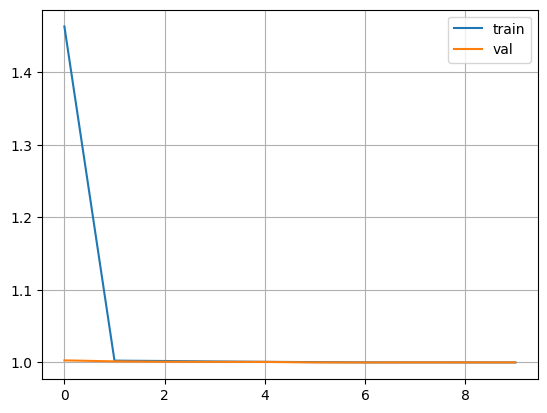

In [7]:
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.grid()
plt.legend()

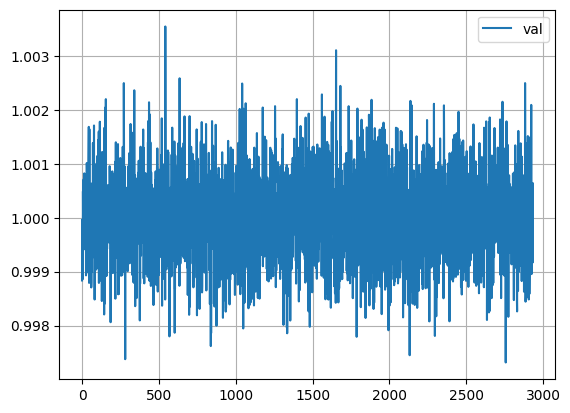

In [8]:
# plt.plot(epo_train_losses, label='train')
plt.plot(epo_train_losses, label='val')
plt.grid()
plt.legend()

In [9]:
audio,image = next(iter(val_loader))
audio_embeds = autoencoder.encode(audio.to(device))
audio_embeds = audio_embeds.permute(0, 2, 1)

model.eval()
generated_image = diffusion.reverse_process(
    model,
    audio_embeds,
    guidance_scale=7.5,
    batch_size=8,
    use_ddim=True,
    timesteps=100  #число шагов
)

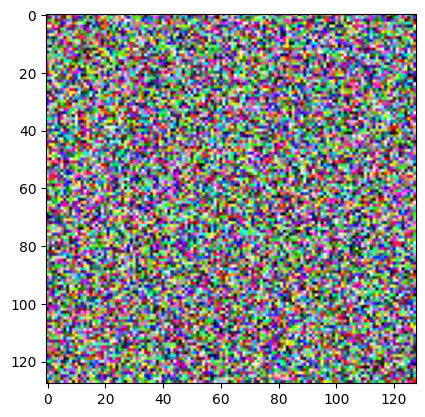

In [10]:
plt.imshow(torch.permute(generated_image[0].cpu()*0.5+0.5, (1,2,0)).numpy())

In [11]:
# датасет обходится за 25 мин, 40 сек
# при num_workers = 8 обходится за ~6 мин 30 сек
# 1300 сек на эпоху

In [12]:
for el in model.mid_block.attn.parameters():
    print("Attention stats:", el.mean().item(), el.max().item())

Attention stats: -7.905332313384861e-05 0.04422502592206001
Attention stats: 0.0005908093880861998 0.04395701736211777
Attention stats: 0.000434914487414062 0.17676685750484467
Attention stats: 0.007631966844201088 0.1761322021484375
Attention stats: 0.00030079903081059456 0.17781585454940796
Attention stats: -0.004018031992018223 0.17600306868553162


In [13]:
torch.save(model.state_dict(), "weights2.pth")